# Multi Agent Systems

## General Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

## Agents

In [2]:
class Bot:
    def __init__(self, rounds, players, bal_per_round, init_balance=0):
        self.balance = init_balance
        self.rounds = rounds
        self.opponents = players - 1
        self.bal_per_round = bal_per_round
        self.curr_round = -1

    def pre_round(self, winner, win_amount):
        self.curr_round += 1
        self.balance += self.bal_per_round
        if winner == 0:
            self.balance -= win_amount

    def play_round(self, winner, win_amount):
        pass

In [3]:
class AllInBot(Bot):
    def play_round(self, winner, win_amount):
        # this agent bids all his money each round
        super().pre_round(winner, win_amount)
        return self.balance

In [4]:
class RandomBot(Bot):
    def play_round(self, winner, win_amount):
        # this agent bids a random amount of money each round
        super().pre_round(winner, win_amount)
        return np.random.randint(0, self.balance)

In [5]:
class CopycatBot(Bot):
    def play_round(self, winner, win_amount):
        super().pre_round(winner, win_amount)
        # if he has as much money as the previous winner he can bid the same amount
        if win_amount <= self.balance and win_amount != -1:
            return win_amount
        else:
            # else he can bid almost all his money, actually 80% of his total
            return self.balance * 0.8

In [6]:
class PercentageBot(Bot):
    def play_round(self, winner, win_amount):
        super().pre_round(winner, win_amount)
        # if the agent lost on the previous round or no one won
        if winner > 0:
            # he will have more money this round so he can save some and bid only 60% of his total
            return self.balance * 0.6
        else:
            # if he won, he will probably have less money so he must bid almost all his money to win
            return self.balance * 0.8

In [7]:
class CounterBot(Bot):
    def __init__(self, rounds, players, bal_per_round, init_balance=0):
        super().__init__(rounds, players, bal_per_round, init_balance)
        self.bank = [init_balance] * (players - 1)
        
    def play_round(self, winner, win_amount):
        super().pre_round(winner, win_amount)
        
        # update the opponents' bank
        for opp in range(self.opponents):
            self.bank[opp] += self.bal_per_round
        
        # update the winner's bank
        if winner > 0:
            self.bank[winner - 1] -= win_amount
        
        # bid more than everyone
        for bid in sorted(self.bank, reverse=True):
            if bid < self.balance:
                return bid + 1
        
        # (almost) all in
        return self.balance - 1

In [8]:
class AverageBot(Bot):
    def __init__(self, rounds, players, bal_per_round, init_balance=0):
        super().__init__(rounds, players, bal_per_round, init_balance)
        self.number = 0
        self.memory = 0

    def play_round(self, winner, win_amount):
        super().pre_round(winner, win_amount)
        if win_amount>0:
            self.number= self.number + 1
            self.memory = self.memory + win_amount
        bid = 0
        if self.balance<=self.bal_per_round*50/100:
            bid = self.balance*60/100
        elif win_amount>0:
            bid = self.memory/self.number
        if bid>self.balance:
            bid = self.balance
        return round(bid)

In [9]:
class EvenBot(Bot):
    def play_round(self, winner, win_amount):
        super().pre_round(winner, win_amount)
        if self.curr_round % 2 != 0 or self.curr_round==(self.rounds-1):
            #print("mpitaro",self.curr_round)
            return self.balance
        else:
            return 1


## Variables

In [10]:
bot_list = [
    # add bots from previous blocks
    AllInBot,
    CopycatBot,
    PercentageBot,
#     CounterBot,
    RandomBot,
    AverageBot,
    EvenBot
]

N = len(bot_list)

## Util Classes

In [11]:
class Bid:
    def __init__(self, index, amount):
        self.index = index
        self.amount = amount

## Auction

In [12]:
import hashlib

def shuffle_order(num_list):
    n = len(num_list)
    hash_index = int(hashlib.sha1(str(num_list).encode()).hexdigest(), 16) % 24
    result = []
    for i in range(n, 0, -1):
        result.append(num_list[hash_index % i])
        del num_list[hash_index % i]
        hash_index //= i
    return result

In [13]:
def auction(agent_indexes, rounds, bal_per_round):
    agent_indexes = shuffle_order(agent_indexes)
    agents = [bot_list[i](rounds, len(agent_indexes), bal_per_round) for i in agent_indexes]

    score = [0] * N
    total = [0] * N
    balance = [0] * N

    (prev_winner, prev_bid) = (-1, -1)
    for _round in range(rounds):
        bids = []
        for i in range(N):
            balance[i] += bal_per_round

            if prev_winner == i:
                prev_winner = 0
            elif prev_winner != -1 and prev_winner < i:
                prev_winner += 1

            bid = int(agents[i].play_round(prev_winner, prev_bid))
            if bid < 0 or bid > balance[i]:
                name = bot_list[agent_indexes[i]].__name__
                raise ValueError("Agent #%s tried to bid with an invalid amount (%d)" % (name, bid))
            bids.append(Bid(i, bid))

        bids.sort(reverse=True, key= lambda b: b.amount)

        winner = -1
        top_bid = bids[0].amount
        for i in range(1, N):
            if bids[i].amount == top_bid:
                winner = -1
                bids[i].amount = -1
                bids[i - 1].amount = -1
            else:
                if bids[i - 1].amount == -1:
                    winner = i
                    top_bid = bids[i].amount
                else:
                    winner = i - 1
                    break

        if winner == -1:
            (prev_winner, prev_bid) = (-1, -1)
        else:
            w_bid = bids[winner]
            (prev_bid, prev_winner) = (w_bid.amount, w_bid.index)
            score[agent_indexes[prev_winner]] += 1
            total[agent_indexes[prev_winner]] += prev_bid
            balance[prev_winner] -= prev_bid

    return score, total

In [14]:
def show_results(score, total):
    results = sorted(map(list, zip(score, total, bot_list)), key= lambda k: (-k[0], k[1]))

    for score, total, agent in results:
        print("%-20s Score: %-6d Total: %d" % (agent.__name__, score, total))

In [15]:
def simulate(experiments=10, rounds=10, bal_per_round=500, print_experiments=True):
    scores = []
    totals = []
    
    for _ in range(experiments):
        agent_indexes = list(range(N))
        (score, total) = auction(agent_indexes, rounds, bal_per_round)
        scores.append(np.array(score))
        totals.append(np.array(total))
        
        if print_experiments:
            print("End of experiment")
            show_results(score, total)
            print()
    
    print("End of simulation")
    score = sum(scores)
    total = sum(totals)
    show_results(score, total)
    return scores, totals

In [16]:
def get_spline(pts):
  n = len(pts)
  x = np.linspace(0, n, 4 * n)
  spl = make_interp_spline(range(n), pts, k=3) # create a cubic spline from the data
  return x, spl(x)

In [17]:
def plot_experiments(bots, experiments, scores):
    results = []
    for i in range(len(bots)):
        score_per_bot = []
        for j in range(experiments):
            score_per_bot.append(scores[j][i])
        results.append(score_per_bot)
    
    
    plt.figure(figsize=(15,6))
    for i in range(len(results)):
        xy = get_spline(results[i])
        plt.plot(xy[0], xy[1], label=bots[i].__name__)
    
    plt.title('Scores per experiment')
    plt.ylim(ymin=0)
    plt.ylim(ymax=max(max(x) for x in scores) + 1)
    plt.legend()

End of simulation
PercentageBot        Score: 17743  Total: 49693203
AverageBot           Score: 17562  Total: 49845725
AllInBot             Score: 17234  Total: 49878000
CopycatBot           Score: 17039  Total: 49820320
EvenBot              Score: 16092  Total: 49901000
RandomBot            Score: 14330  Total: 49771383


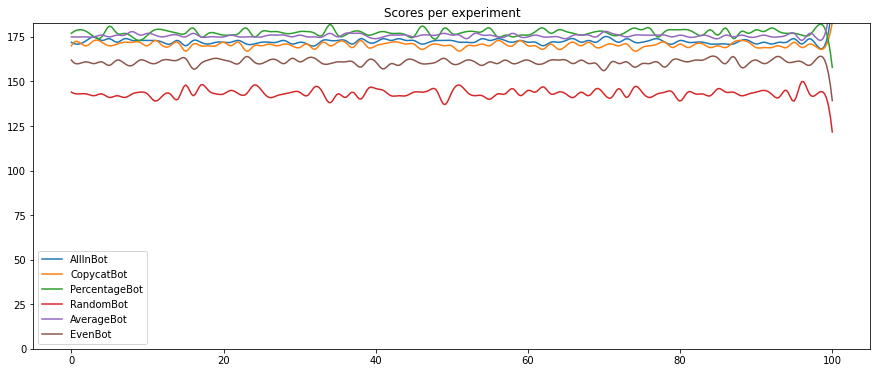

In [18]:
experiments = 100
rounds = 1000

scores, totals = simulate(experiments, rounds, print_experiments=False)
plot_experiments(bot_list, experiments, scores)